# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [346]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn import datasets
import copy

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [609]:
class Perceptron:
    def __init__(self, iterations=10000):
        self.w = np.array([0.0, 0.0, 0.0]) # c + x + y = 0
        self.n_iterations = iterations
    
    def fit(self, X, y):
        count_iteration = 0
        while count_iteration != self.n_iterations:
            for x, true_label in zip(X, y):
                x = np.append(np.array([1]), x)
                if self.get_label_predict(x) != true_label:
                    self.w += -x if true_label == 0 else x
                    break
            count_iteration += 1
    
    def get_label(self, x):
        return 1 if np.dot(x, self.w) > 0 else -1
    
    def get_label_predict(self, x):
        return 1 if np.dot(x, self.w) > 0 else 0
    
    def predict(self, X):
        predict_labels = []
        for x in X:
            x = np.append(np.array([1]), x)
            predict_labels.append(self.get_label_predict(x))
        return predict_labels

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

0.96


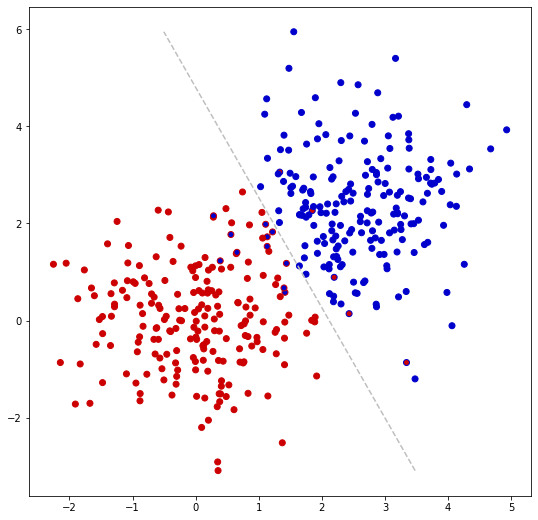

In [614]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
print(accuracy_score(true_labels, c.predict(X)))
visualize(X, true_labels, np.array(c.predict(X)), c.w)

0.7375


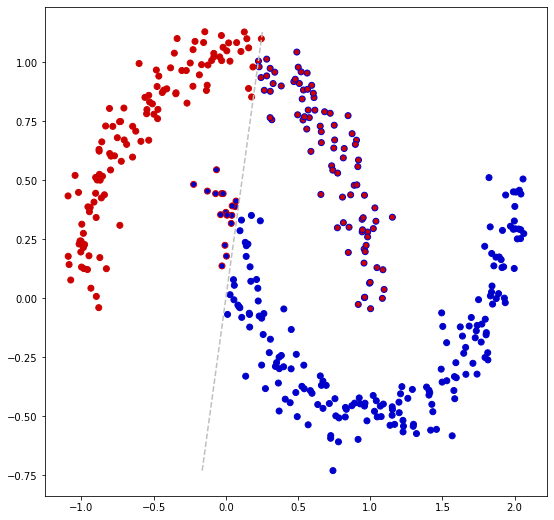

In [615]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
print(accuracy_score(true_labels, c.predict(X)))
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [688]:
class PerceptronBest:
    def __init__(self, iterations=100):
        self.w = np.array([0.0, 0.0, 0.0]) # c + x + y = 0
        self.n_iterations = iterations
    
    def fit(self, X, y):
        count_iteration = 0
        current_acc = 0
        while count_iteration != self.n_iterations:
            for x, true_label in zip(X, y):
                x = np.append(np.array([1]), x)
                if self.get_label_predict(x) != true_label:
                    self.w += -x if true_label == 0 else x
                    if accuracy_score(y, self.predict(X)) > current_acc:
                        current_acc = accuracy_score(y, self.predict(X))
                        best_w = self.w
                    break
            count_iteration += 1
        self.w = best_w
    
    def get_label_predict(self, x):
        return 1 if np.dot(x, self.w) > 0 else 0
    
    def predict(self, X):
        predict_labels = []
        for x in X:
            x = np.append(np.array([1]), x)
            predict_labels.append(self.get_label_predict(x))
        return predict_labels

In [619]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

0.975


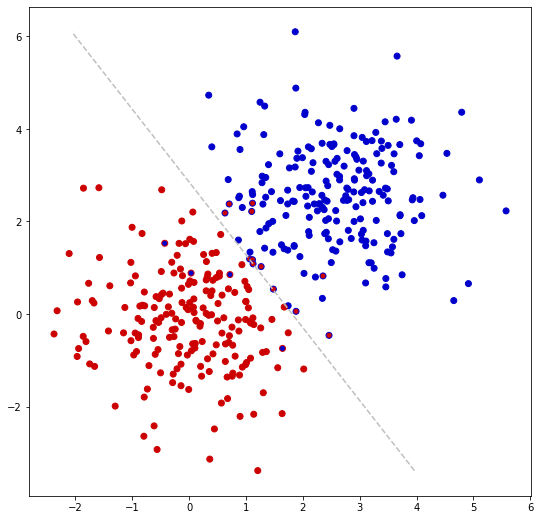

In [620]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

0.8775


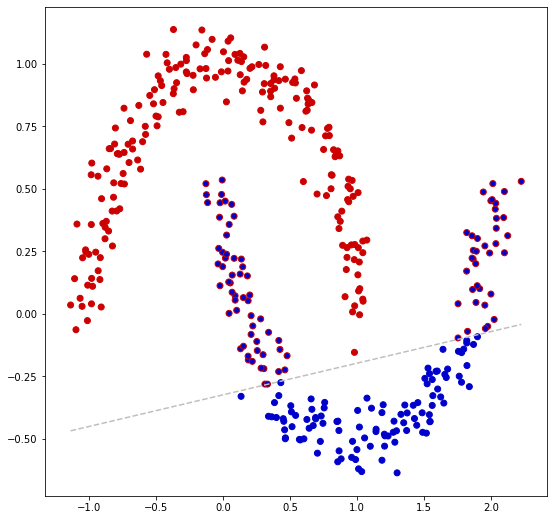

In [621]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [681]:
def transform_images(images):
    labels = []
    for image in images:
        col_max, count_up, count_down = 0, 0, 0
        for x in range(8):
            cur_max = 0
            for y in range(8):
                if image[y][x] == 1:
                    cur_max += 1
            col_max = max(cur_max, col_max)
        for y in range(8):
            for z in range(8):
                if y < 4:
                    count_up += image[y][z]
                else:
                    count_down += image[y][z]
        labels.append(np.array([count_down - count_up, col_max / 8]))
    return np.array(labels)
def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [682]:
X, y = get_digits()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [683]:
le = LabelEncoder()
le.fit(y_train)
y_train, y_test = le.transform(y_train), le.transform(y_test)

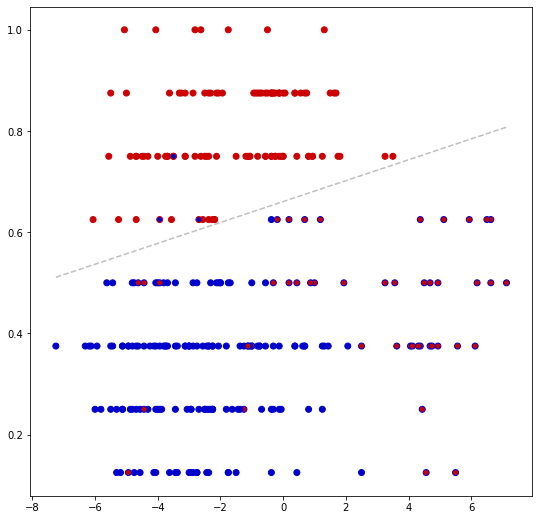

Accuracy: 0.8493150684931506


In [684]:
c = Perceptron(iterations=10000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

0.9278350515463918


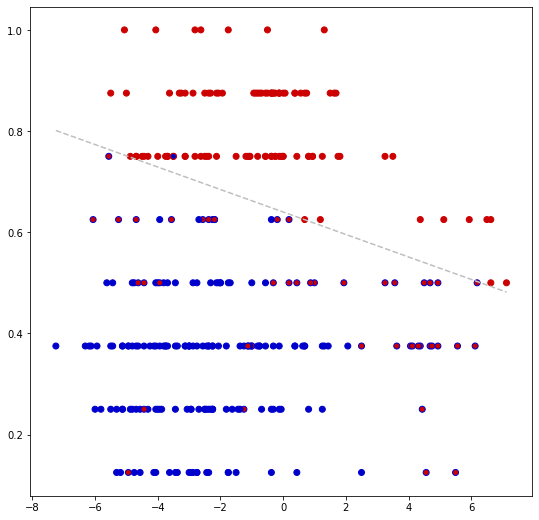

Accuracy: 0.8767123287671232


In [685]:
c = PerceptronBest(iterations=1000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [686]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    le = LabelEncoder()
    le.fit(y_train)
    y_train, y_test = le.transform(y_train), le.transform(y_test)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.7648813904907544


In [689]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    le = LabelEncoder()
    le.fit(y_train)
    y_train, y_test = le.transform(y_train), le.transform(y_test)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.7648813904907544
